Small dataset created!
Using device: cpu

Training...

Epoch 1 Loss 0.6216477513313293
Epoch 2 Loss 0.5977079510688782


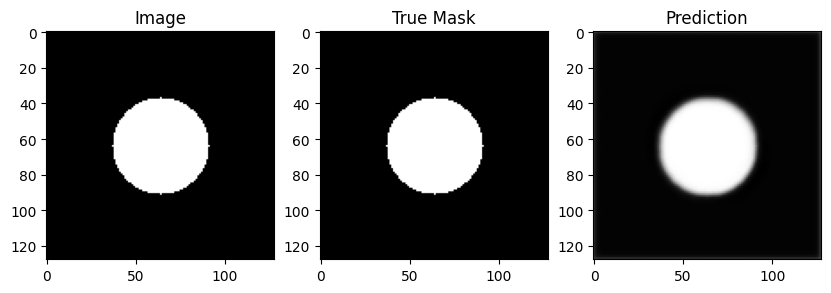

In [ ]:
# ======================================
# FAST MEDICAL SEGMENTATION DEMO
# ======================================

!pip install torch torchvision matplotlib opencv-python -q

import os, cv2, torch, numpy as np, matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# -----------------------------
# SMALL DATASET (FASTER)
# -----------------------------
os.makedirs("dataset/images", exist_ok=True)
os.makedirs("dataset/masks", exist_ok=True)

for i in range(10):  # reduced dataset
    img = np.zeros((128,128), dtype=np.uint8)
    radius = np.random.randint(20,40)
    cv2.circle(img, (64,64), radius, 255, -1)
    mask = img.copy()

    cv2.imwrite(f"dataset/images/img{i}.png", img)
    cv2.imwrite(f"dataset/masks/img{i}.png", mask)

print("Small dataset created!")

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# -----------------------------
# DATASET CLASS
# -----------------------------
class MedicalDataset(Dataset):
    def __init__(self, img_dir, mask_dir):
        self.images = os.listdir(img_dir)
        self.img_dir = img_dir
        self.mask_dir = mask_dir

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        name = self.images[idx]
        img = cv2.imread(os.path.join(self.img_dir,name),0)/255.0
        mask = cv2.imread(os.path.join(self.mask_dir,name),0)/255.0
        img = torch.tensor(img,dtype=torch.float32).unsqueeze(0)
        mask = torch.tensor(mask,dtype=torch.float32).unsqueeze(0)
        return img, mask

# -----------------------------
# LIGHTWEIGHT U-NET
# -----------------------------
class DoubleConv(nn.Module):
    def __init__(self,i,o):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(i,o,3,padding=1), nn.ReLU(),
            nn.Conv2d(o,o,3,padding=1), nn.ReLU()
        )
    def forward(self,x):
        return self.net(x)

class SmallUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.d1 = DoubleConv(1,16)   # reduced filters
        self.d2 = DoubleConv(16,32)
        self.pool = nn.MaxPool2d(2)
        self.u1 = DoubleConv(32+16,16)
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.out = nn.Conv2d(16,1,1)

    def forward(self,x):
        c1 = self.d1(x)
        p1 = self.pool(c1)
        c2 = self.d2(p1)
        u1 = self.up(c2)
        u1 = torch.cat([u1,c1],1)
        c3 = self.u1(u1)
        return torch.sigmoid(self.out(c3))

# -----------------------------
# TRAIN
# -----------------------------
dataset = MedicalDataset("dataset/images","dataset/masks")
loader = DataLoader(dataset,batch_size=2,shuffle=True)

model = SmallUNet().to(device)
opt = torch.optim.Adam(model.parameters(),1e-3)
loss_fn = nn.BCELoss()

print("\nTraining...\n")
for epoch in range(2):  # reduced epochs
    total=0
    for img,mask in loader:
        img,mask = img.to(device), mask.to(device)
        pred = model(img)
        loss = loss_fn(pred,mask)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total+=loss.item()
    print("Epoch",epoch+1,"Loss",total/len(loader))

# -----------------------------
# TEST
# -----------------------------
model.eval()
img,mask = dataset[0]

with torch.no_grad():
    pred = model(img.unsqueeze(0).to(device))[0][0].cpu()

plt.figure(figsize=(10,3))
plt.subplot(1,3,1); plt.title("Image"); plt.imshow(img[0],cmap="gray")
plt.subplot(1,3,2); plt.title("True Mask"); plt.imshow(mask[0],cmap="gray")
plt.subplot(1,3,3); plt.title("Prediction"); plt.imshow(pred,cmap="gray")
plt.show()